In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #by default doesnt do anything for a leaf node there is nothing to do
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    #implimented by addition of a negation
    def __sub__(self, other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            #multiply base by exponent subtract exponent by 1
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [88]:
#code to visualize expression graphs
# Creates new function draw_dot on some root note to visualize it

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [89]:
#RESETING GRADIENT

# Inputs x1, x1 (2 dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label="b")

#bias of the neuron
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

#x1*w1 + x2*w2 * b we do it in small steps so we can maintian pointers to all the intermediate nodes
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"

#n is now cell body
n = x1w1x2w2 + b; n.label="n"

#now we take it through activation function
#this is mathematically equivalant to tanh there for gradient at leaf nodes in both forward pass and backword pass works
e = (2*n).exp()
o = (e-1) / (e+1)
o.label="o"
o.backward()

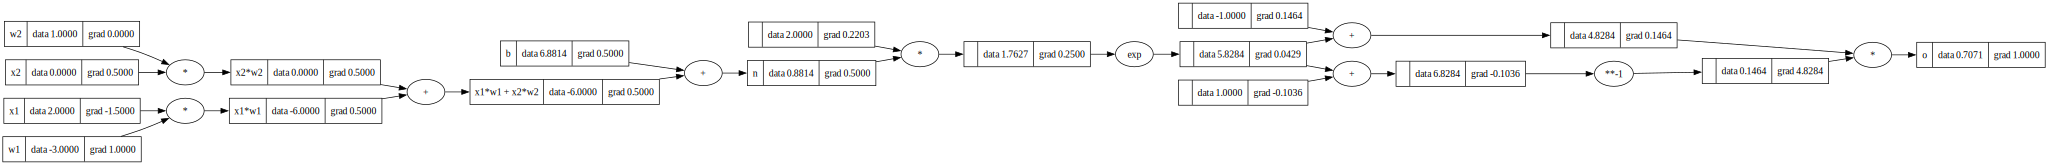

In [90]:
draw_dot(o)

How we can acheive the same as above with pytorch:

In [91]:
import torch


In [92]:
x1 = torch.Tensor([2.0]).double()                   ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [245]:
import random

In [254]:
class Neuron:
    #nin: number if inputs
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        #w *x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    #gather params
    def parameters(self):
        return self.w + [self.b]
    

In [255]:
#next we will define a layer of neurons
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [256]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [257]:

x = [2.0,3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)



Value(data=0.8352367531940261)

In [258]:
#all the wieghts and biases in the neural net
n.parameters()

[Value(data=-0.28954623373419164),
 Value(data=-0.5828251228729795),
 Value(data=-0.7141953848842495),
 Value(data=0.6600397954329602),
 Value(data=0.24865383737127988),
 Value(data=0.3451569376942041),
 Value(data=0.20192673321376708),
 Value(data=0.49309614294569437),
 Value(data=-0.4935192254346703),
 Value(data=0.12125758043717538),
 Value(data=-0.7776093729871878),
 Value(data=-0.6723426113849509),
 Value(data=-0.08987210420061165),
 Value(data=0.33022304528725477),
 Value(data=-0.7158254825694073),
 Value(data=0.9014362318504019),
 Value(data=0.5346725188618575),
 Value(data=0.39532360755745555),
 Value(data=0.10763721174270358),
 Value(data=0.19466174564420302),
 Value(data=-0.6176717375196035),
 Value(data=-0.15898310817145367),
 Value(data=-0.8780039290713466),
 Value(data=-0.6180983853927471),
 Value(data=-0.7332017164880995),
 Value(data=-0.4202468285664218),
 Value(data=-0.8031598027767153),
 Value(data=0.9796419537703216),
 Value(data=-0.2617273492788086),
 Value(data=-0.6

In [259]:
#example data set with 4 possible inputs into the neural net and 4 desired targets

xs = [
    [2.0,3.0,-1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
#simple binary classifer neural net
ys = [1.0, -1.0,-1.0,1.0] #desired targets (we would like the neural net to output 1.0 when fed xs[0], -1.0 when fed xs[1], -1.0 when def xs[2] ...)

In [284]:
#how do we tune the weights to get the desired outputs?
#The trick used in deep learning to acheive this is too calculate a single number that somehow measures the total performance of your neural net
#we call this single number the loss (measures how well the neural net is performing) so far the loss will be high since the neural net is not perfomring very well
#what does the neural net currently thinks about these 4 examples
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    #in this case we will impliment the 
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)
#for each one of the 4 we are taking the prediction and the g truth and we are squaring them and subtracting them.
#If it is so close to its target, subtracting them gives a very small number, so here we would get a negative .1 and squaring it just makes sure that regardless of whether we ar more negative or more positive we will always get a positive number
#this when the prediciton is exactly 0, we will get the target
#the more off we are the greater the loss will be. We dont want high loss we want low loss
#final loss will be the sum of all these numbers

0 0.0014107119460989696
1 0.0014045265649731183
2 0.0013983948125988333
3 0.0013923159973694924
4 0.0013862894394861228
5 0.0013803144707070299
6 0.0013743904341037728
7 0.0013685166838232742
8 0.0013626925848558473
9 0.0013569175128090548
10 0.001351190853687243
11 0.001345512003676439
12 0.0013398803689346527
13 0.0013342953653872598
14 0.0013287564185274177
15 0.0013232629632213783
16 0.0013178144435185227
17 0.0013124103124658654
18 0.0013070500319272908
19 0.0013017330724068223


In [285]:
ypred

[Value(data=0.9840106859443328),
 Value(data=-0.985982260430483),
 Value(data=-0.9722362860237522),
 Value(data=0.9911256508947209)]